In [1]:
!pip install -r requirements.txt

In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

<div style="text-align: center;">
    <strong><em>Histopathologic Cancer Detection</em></strong>
</div>

### Problem Description

<div style="text-align: center;">
    <strong><em>Dataset Description</em></strong>
</div>

In [5]:
#Define the paths 
train_path = "data/train"
test_path = "data/test"
train_data = pd.read_csv("data/train_labels.csv")

<div style="text-align: center;">
    <strong><em>EDA</em></strong>
</div>

In [6]:
# Define the train and valid data
train_data["label"] = train_data["label"].astype(float)

# Split the data into train and validation
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Index: 176020 entries, 2425 to 121958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      176020 non-null  object 
 1   label   176020 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.0+ MB
                                              id  label
2425    6e4e15501c5b5d76de47a606bd5adcc31259bf28    0.0
41861   b82a02a1328853929fb59366f45f25041edf6997    1.0
186299  7b80456230e98ca1671a2645bdf4bb1fddaf7ef2    0.0
54730   db24a0b08e62c7795874b839bd8e1feb981a1c27    1.0
31665   ac4901d3dee2875e0619461fcf6495e0db78eecd    0.0
               label
count  176020.000000
mean        0.405005
std         0.490894
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


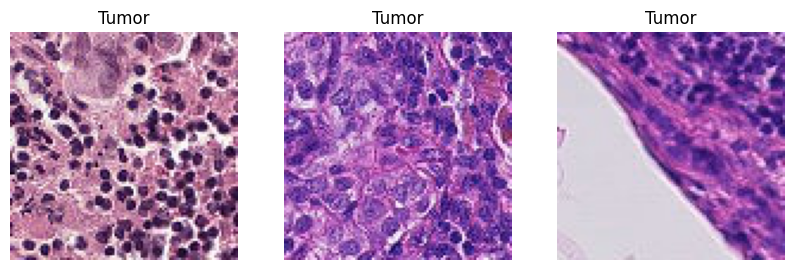

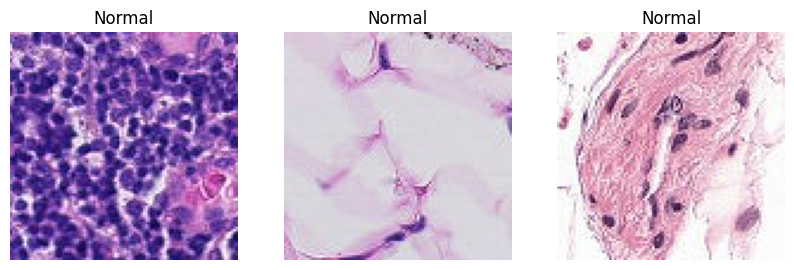

In [7]:
# Perform EDA
train_data.info()
print(train_data.head())
print(train_data.describe())

# Remove unnecessary data
train_data.drop_duplicates()
train_data = train_data.dropna(axis=0, subset=["label"])

# Remove unnecessary data from valid data
valid_data.drop_duplicates()
valid_data = valid_data.dropna(axis=0, subset=["label"])

# Visual data
sample_tumor_ids = train_data[train_data["label"] == 1]["id"].sample(n=3).values
sample_normal_ids = train_data[train_data["label"] == 0]["id"].sample(n=3).values

tumor_images = []
for id in sample_tumor_ids:
    image_path = os.path.join(train_path, id + ".tif")
    tumor_images.append(Image.open(image_path))

normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_path, id + ".tif")
    normal_images.append(Image.open(image_path))

plt.figure(figsize=(10, 3))
for i, image in enumerate(tumor_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title("Tumor")
    plt.axis("off")
plt.show()

plt.figure(figsize=(10, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title("Normal")
    plt.axis("off")
plt.show()

<div style="text-align: center;">
    <strong><em>Histograms</em></strong>
</div>

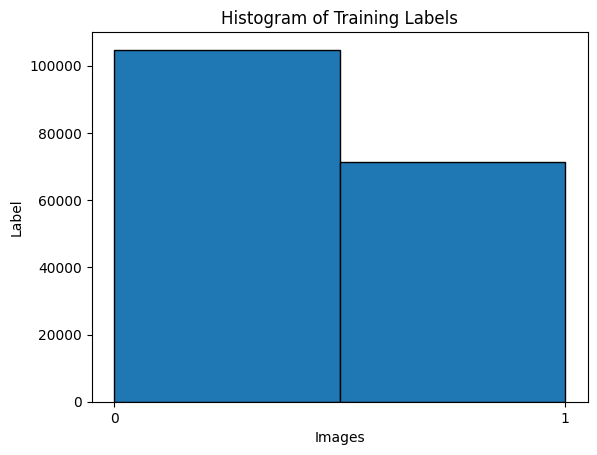

In [8]:
plt.hist(train_data['label'], bins=2, edgecolor='black')
plt.xticks([0, 1])
plt.xlabel('Images')
plt.ylabel('Label')
plt.title('Histogram of Training Labels')
plt.show()

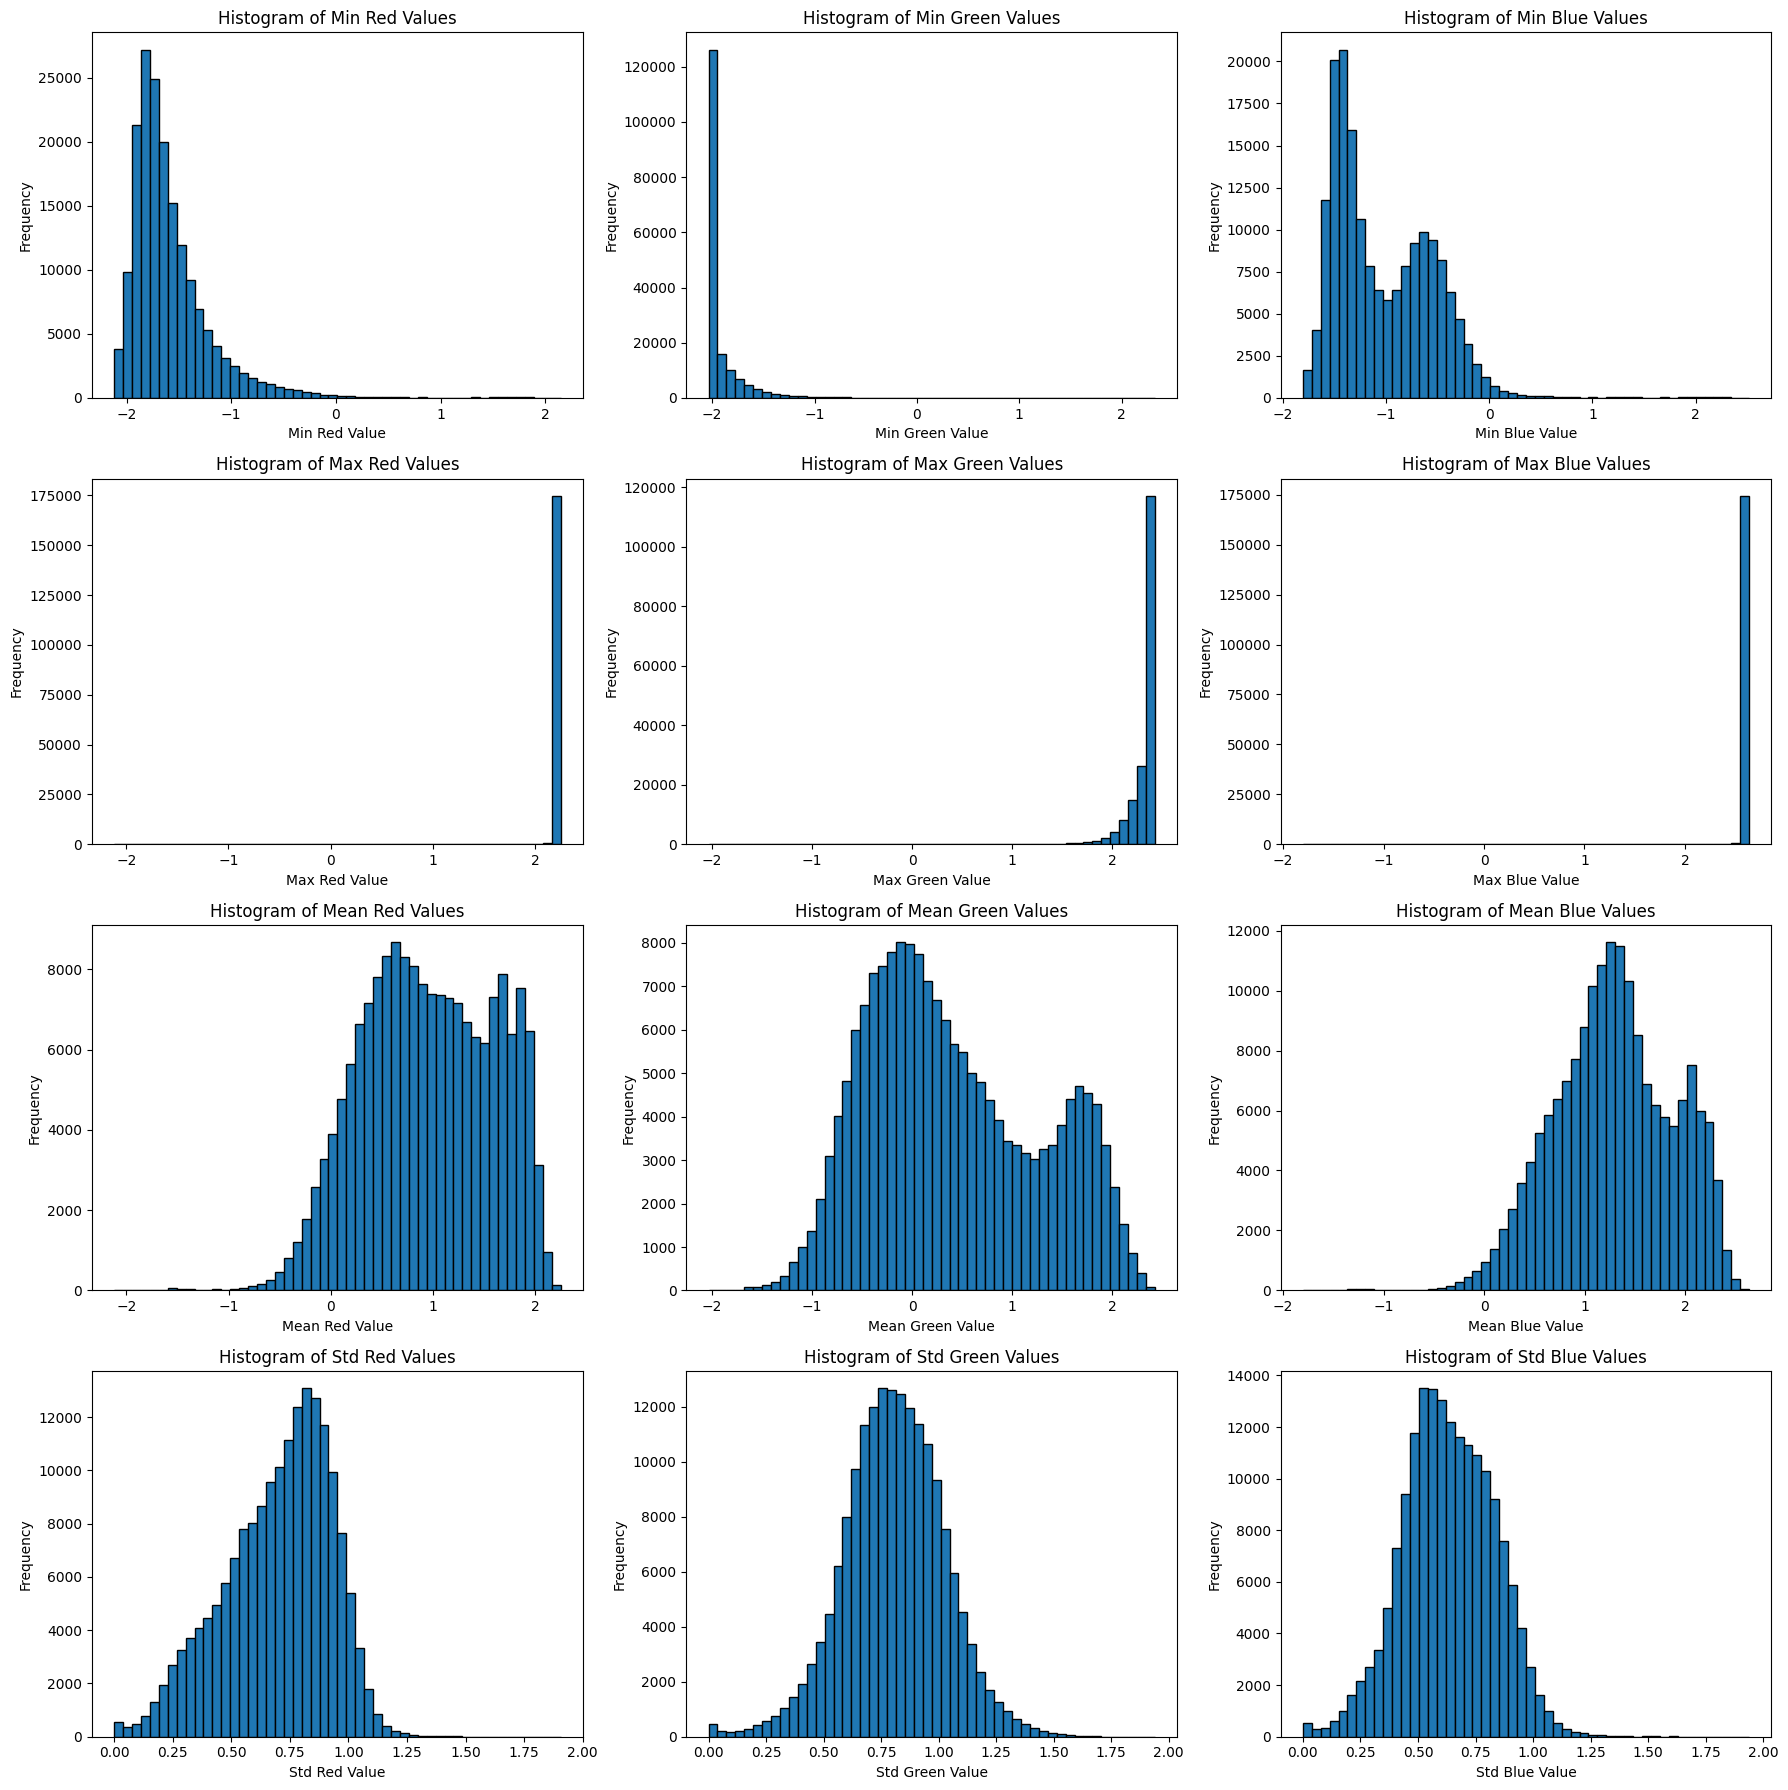

In [9]:
# Initialize lists to store pixel values for each channel
min_red_values = []
max_red_values = []
mean_red_values = []
std_red_values = []

min_green_values = []
max_green_values = []
mean_green_values = []
std_green_values = []

min_blue_values = []
max_blue_values = []
mean_blue_values = []
std_blue_values = []

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Iterate through the DataFrame
for idx, row in train_data.iterrows():
    img_id = row['id']
    img_path = os.path.join(train_path, img_id + '.tif')
    image = Image.open(img_path).convert('RGB')  # Ensure the image is in RGB format

    # Apply transformations
    image = transform(image)
    
    # Separate the RGB channels
    red_channel = image[0]  # Extract red channel
    green_channel = image[1]  # Extract green channel
    blue_channel = image[2]  # Extract blue channel

    # Compute min, max, mean, and std pixel values for each channel
    min_red_values.append(red_channel.min().item())
    max_red_values.append(red_channel.max().item())
    mean_red_values.append(red_channel.mean().item())
    std_red_values.append(red_channel.std().item())
    
    min_green_values.append(green_channel.min().item())
    max_green_values.append(green_channel.max().item())
    mean_green_values.append(green_channel.mean().item())
    std_green_values.append(green_channel.std().item())
    
    min_blue_values.append(blue_channel.min().item())
    max_blue_values.append(blue_channel.max().item())
    mean_blue_values.append(blue_channel.mean().item())
    std_blue_values.append(blue_channel.std().item())

# Plot histograms of min, max, mean, and std pixel values for each channel
plt.figure(figsize=(18, 18))

# Min values
plt.subplot(4, 3, 1)
plt.hist(min_red_values, bins=50, edgecolor='black')
plt.xlabel('Min Red Value')
plt.ylabel('Frequency')
plt.title('Histogram of Min Red Values')

plt.subplot(4, 3, 2)
plt.hist(min_green_values, bins=50, edgecolor='black')
plt.xlabel('Min Green Value')
plt.ylabel('Frequency')
plt.title('Histogram of Min Green Values')

plt.subplot(4, 3, 3)
plt.hist(min_blue_values, bins=50, edgecolor='black')
plt.xlabel('Min Blue Value')
plt.ylabel('Frequency')
plt.title('Histogram of Min Blue Values')

# Max values
plt.subplot(4, 3, 4)
plt.hist(max_red_values, bins=50, edgecolor='black')
plt.xlabel('Max Red Value')
plt.ylabel('Frequency')
plt.title('Histogram of Max Red Values')

plt.subplot(4, 3, 5)
plt.hist(max_green_values, bins=50, edgecolor='black')
plt.xlabel('Max Green Value')
plt.ylabel('Frequency')
plt.title('Histogram of Max Green Values')

plt.subplot(4, 3, 6)
plt.hist(max_blue_values, bins=50, edgecolor='black')
plt.xlabel('Max Blue Value')
plt.ylabel('Frequency')
plt.title('Histogram of Max Blue Values')

# Mean values
plt.subplot(4, 3, 7)
plt.hist(mean_red_values, bins=50, edgecolor='black')
plt.xlabel('Mean Red Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Red Values')

plt.subplot(4, 3, 8)
plt.hist(mean_green_values, bins=50, edgecolor='black')
plt.xlabel('Mean Green Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Green Values')

plt.subplot(4, 3, 9)
plt.hist(mean_blue_values, bins=50, edgecolor='black')
plt.xlabel('Mean Blue Value')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Blue Values')

# Standard Deviation values
plt.subplot(4, 3, 10)
plt.hist(std_red_values, bins=50, edgecolor='black')
plt.xlabel('Std Red Value')
plt.ylabel('Frequency')
plt.title('Histogram of Std Red Values')

plt.subplot(4, 3, 11)
plt.hist(std_green_values, bins=50, edgecolor='black')
plt.xlabel('Std Green Value')
plt.ylabel('Frequency')
plt.title('Histogram of Std Green Values')

plt.subplot(4, 3, 12)
plt.hist(std_blue_values, bins=50, edgecolor='black')
plt.xlabel('Std Blue Value')
plt.ylabel('Frequency')
plt.title('Histogram of Std Blue Values')

plt.tight_layout()
plt.show()

<div style="text-align: center;">
    <strong><em>Image Standardization and Transformation</em></strong>
</div>

In [8]:
# Define transformations
std_transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize the image to 96x96
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

***Define Transformations***


```transforms.Resize((96, 96))```: Resize the images to 96x96 pixels.


```transforms.ToTensor()```: Convert the images to tensors.


```transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])```: Standardize the images using mean and standard deviation values commonly used for 
pre-trained models.




In [12]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# Data definition
class TumorDataset(Dataset):
    def __init__(self, image_dir, label_df, transform=None):
        self.image_dir = image_dir
        self.labels = label_df
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_id = self.labels.iloc[idx]["id"]
        label = self.labels.iloc[idx]["label"]
        img_path = os.path.join(self.image_dir, img_id) + ".tif"
        imageLoaded = Image.open(img_path)
        label = torch.tensor(label, dtype=torch.float32)
        if self.transform:
            imageLoaded = self.transform(imageLoaded)
        return imageLoaded, label


train_dataset = TumorDataset(image_dir=train_path, label_df=train_data, transform=std_transform)
valid_dataset = TumorDataset(image_dir=train_path, label_df=valid_data, transform=std_transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=1024, shuffle=True, num_workers=16, pin_memory=True
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=1024, shuffle=False, num_workers=16, pin_memory=True
)


<div style="text-align: center;">
    <strong><em>Model Selection</em></strong>
</div>

In [14]:
# Model Definition
class ExtendedResNet50(nn.Module):
    def __init__(self, weights=True):
        super(ExtendedResNet50, self).__init__()
        self.resnet = models.resnet50(weights='IMAGENET1K_V2' if weights else None)
        in_features = self.resnet.fc.in_features

        # Replace the original fully connected layer with an identity layer
        self.resnet.fc = nn.Identity()

        self.new_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),  # Single output for binary classification
        )

    def forward(self, x):
        rx = self.resnet(x)
        output = self.new_fc(rx)
        return output

class ExtendedResNet18(nn.Module):
    def __init__(self, weights=True):
        super(ExtendedResNet18, self).__init__()
        self.resnet = models.resnet18(weights='IMAGENET1K_V1' if weights else None)
        in_features = self.resnet.fc.in_features

        # Replace the original fully connected layer with an identity layer
        self.resnet.fc = nn.Identity()

        self.new_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),  # Single output for binary classification
        )

    def forward(self, x):
        rx = self.resnet(x)
        output = self.new_fc(rx)
        return output

class ExtendedVGG16(nn.Module):
    def __init__(self, weights=True):
        super(ExtendedVGG16, self).__init__()
        self.vgg = models.vgg16(weights='IMAGENET1K_V1' if weights else None)
        in_features = 25088  # Updated to match the output of VGG16

        # Replace the original classifier with an identity layer
        self.vgg.classifier = nn.Identity()

        self.new_fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),  # Single output for binary classification
        )

    def forward(self, x):
        vx = self.vgg(x)
        output = self.new_fc(vx)
        return output

<div style="text-align: center;">
    <strong><em>Hyperparameter Explanation</em></strong>
</div>

Defining the loss function, optimizer, learning rate scheduler, and gradient scaler is crucial for an effective neural network training pipeline. The nn.BCEWithLogitsLoss() function is chosen for binary classification tasks as it combines a Sigmoid layer and binary cross-entropy loss in a numerically stable way, making it suitable for scenarios where the model outputs probabilities for a positive class. The Adam optimizer (optim.Adam) is used for its efficiency and effectiveness, offering adaptive learning rates for each parameter based on gradient moments, with a specified learning rate of 0.001. To further refine training, the StepLR scheduler adjusts the learning rate by a factor of 0.001 every 5 epochs, helping the model converge more smoothly. Additionally, GradScaler is employed to enable mixed precision training on GPUs, improving computational efficiency and speeding up the training process.

In [15]:
# Function to predict and calculate loss for a given model and dataloader
def predict(model, dataloader):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            all_outputs.extend(sigmoid_outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loss = criterion(outputs, labels.view(-1, 1))
            total_loss += loss.item()

    return np.array(all_labels), np.array(all_outputs), total_loss / len(dataloader)

Epoch [1/15], Train Loss: 0.2702, Val Loss: 0.1914
Epoch [2/15], Train Loss: 0.1746, Val Loss: 0.1552
Epoch [3/15], Train Loss: 0.1444, Val Loss: 0.1447
Epoch [4/15], Train Loss: 0.1248, Val Loss: 0.1330
Epoch [5/15], Train Loss: 0.1072, Val Loss: 0.1245
Epoch [6/15], Train Loss: 0.0837, Val Loss: 0.1145
Epoch [7/15], Train Loss: 0.0792, Val Loss: 0.1132
Epoch [8/15], Train Loss: 0.0759, Val Loss: 0.1172
Epoch [9/15], Train Loss: 0.0733, Val Loss: 0.1158
Epoch [10/15], Train Loss: 0.0707, Val Loss: 0.1157
Epoch [11/15], Train Loss: 0.0672, Val Loss: 0.1139
Epoch [12/15], Train Loss: 0.0667, Val Loss: 0.1136
Epoch [13/15], Train Loss: 0.0662, Val Loss: 0.1135
Epoch [14/15], Train Loss: 0.0660, Val Loss: 0.1137
Epoch [15/15], Train Loss: 0.0659, Val Loss: 0.1136
Training finished.


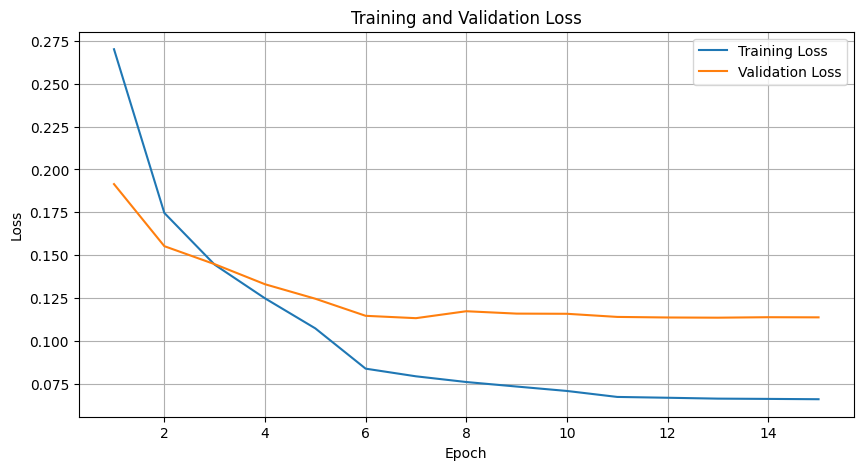

In [16]:
# Instantiate the model and move it to the selected device
vgg_model_binary = ExtendedVGG16(weights=True)
vgg_model_binary.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg_model_binary.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 15

scaler = GradScaler('cuda')

# Lists to store the losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    vgg_model_binary.train()
    running_loss = 0.0
    data_iter = iter(train_dataloader)

    next_batch = next(data_iter)
    next_batch = [tensor.to(device, non_blocking=True) for tensor in next_batch]

    for i in range(len(train_dataloader)):
        batch = next_batch
        images, labels = batch

        if i + 1 != len(train_dataloader):
            next_batch = next(data_iter)
            next_batch = [tensor.to(device, non_blocking=True) for tensor in next_batch]

        optimizer.zero_grad()

        with autocast(device.type):
            outputs = vgg_model_binary(images)
            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)

        if torch.isnan(loss):
            print("Loss became NaN. Stopping training.")
            break

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(vgg_model_binary.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    scheduler.step()

    # Store average training loss for this epoch
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation step
    val_labels, val_outputs, val_loss = predict(vgg_model_binary, valid_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training finished.")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch [1/15], Loss: 0.1704
Epoch [2/15], Loss: 0.0817
Epoch [3/15], Loss: 0.0553
Epoch [4/15], Loss: 0.0412
Epoch [5/15], Loss: 0.0320
Epoch [6/15], Loss: 0.0106
Epoch [7/15], Loss: 0.0031
Epoch [8/15], Loss: 0.0018
Epoch [9/15], Loss: 0.0014
Epoch [10/15], Loss: 0.0012
Epoch [11/15], Loss: 0.0010
Epoch [12/15], Loss: 0.0009
Epoch [13/15], Loss: 0.0009
Epoch [14/15], Loss: 0.0009
Epoch [15/15], Loss: 0.0008
Training finished.


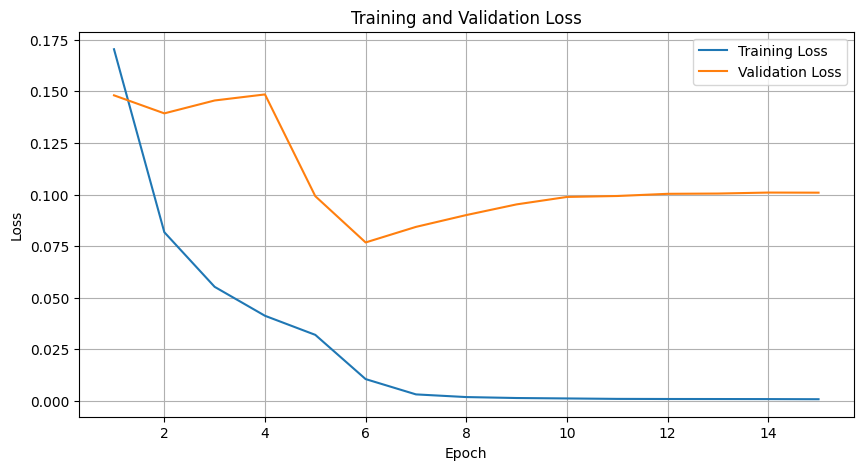

In [17]:
# Instantiate the model and move it to the selected device
resnet_model_binary = ExtendedResNet50(weights=True)
resnet_model_binary.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet_model_binary.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 15
resnet_model_binary.train()  # Set model to training mode

scaler = GradScaler('cuda')

# Lists to store the losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    resnet_model_binary.train()
    running_loss = 0.0
    data_iter = iter(train_dataloader)

    # Prepare the first batch
    next_batch = next(data_iter)
    next_batch = [tensor.to(device, non_blocking=True) for tensor in next_batch]

    for i in range(len(train_dataloader)):
        batch = next_batch
        images, labels = batch

        if i + 1 != len(train_dataloader):
            next_batch = next(data_iter)
            next_batch = [tensor.to(device, non_blocking=True) for tensor in next_batch]

        optimizer.zero_grad()

        with autocast(device.type):
            outputs = resnet_model_binary(images)
            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    scheduler.step()

    # Store average training loss for this epoch
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation step
    val_labels, val_outputs, val_loss = predict(resnet_model_binary, valid_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}")

print("Training finished.")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch [1/15], Loss: 0.1938
Epoch [2/15], Loss: 0.1128
Epoch [3/15], Loss: 0.0821
Epoch [4/15], Loss: 0.0568
Epoch [5/15], Loss: 0.0443
Epoch [6/15], Loss: 0.0136
Epoch [7/15], Loss: 0.0057
Epoch [8/15], Loss: 0.0034
Epoch [9/15], Loss: 0.0025
Epoch [10/15], Loss: 0.0023
Epoch [11/15], Loss: 0.0018
Epoch [12/15], Loss: 0.0015
Epoch [13/15], Loss: 0.0014
Epoch [14/15], Loss: 0.0014
Epoch [15/15], Loss: 0.0013
Training finished.


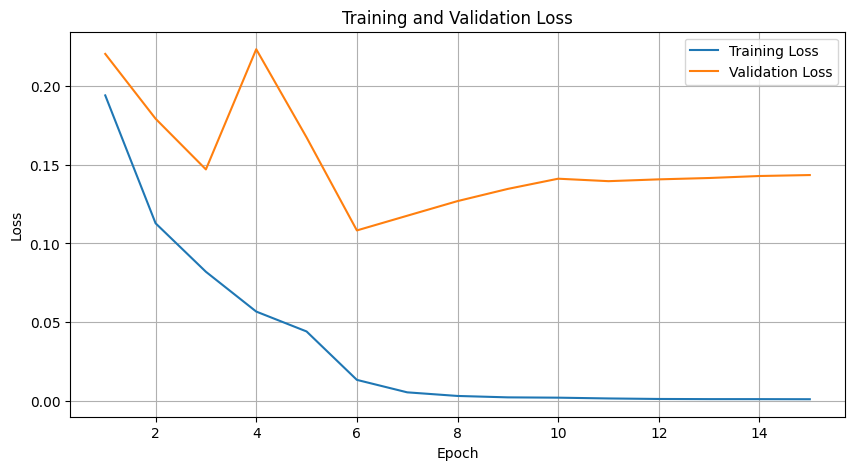

In [18]:
# Instantiate the model and move it to the selected device
resnet_model_binary = ExtendedResNet18(weights=True)
resnet_model_binary.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet_model_binary.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 15
resnet_model_binary.train()  # Set model to training mode

scaler = GradScaler('cuda')

# Lists to store the losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    resnet_model_binary.train()
    running_loss = 0.0
    data_iter = iter(train_dataloader)

    # Prepare the first batch
    next_batch = next(data_iter)
    next_batch = [tensor.to(device, non_blocking=True) for tensor in next_batch]

    for i in range(len(train_dataloader)):
        batch = next_batch
        images, labels = batch

        if i + 1 != len(train_dataloader):
            next_batch = next(data_iter)
            next_batch = [tensor.to(device, non_blocking=True) for tensor in next_batch]

        optimizer.zero_grad()

        with autocast(device.type):
            outputs = resnet_model_binary(images)
            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    scheduler.step()

    # Store average training loss for this epoch
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation step
    val_labels, val_outputs, val_loss = predict(resnet_model_binary, valid_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}")

print("Training finished.")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<div style="text-align: center;">
    <strong><em>Summary of Training</em></strong>
</div>

<div style="text-align: center;">
    <strong><em>Improvements</em></strong>
</div>